In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns

from xgboost import XGBClassifier
import optuna

from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV
)
from sklearn.metrics import (
    recall_score, f1_score, roc_auc_score,
    accuracy_score, precision_score,
    roc_curve, precision_recall_curve, auc,
    ConfusionMatrixDisplay, confusion_matrix
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [10]:
# Load data for Tram
data = pd.read_csv("/Users/tbhuynh/Desktop/UNC_PHD/BIOS635/Final Project/train.csv")
submission = pd.read_csv("/Users/tbhuynh/Desktop/UNC_PHD/BIOS635/Final Project/test.csv")

In [3]:
# Load data for Ashley
data = pd.read_csv("C:/Users/ashle/OneDrive/Documents/Courses/UNC Courses/BIOS 635 - ML/Final/train.csv")
submission = pd.read_csv("C:/Users/ashle/OneDrive/Documents/Courses/UNC Courses/BIOS 635 - ML/Final/test.csv")

In [4]:
# Save the 'id' column from submission before dropping
submission_ids = submission['id'].copy()

# Drop 'id' and 'Name' from both datasets
data.drop(columns=['id', 'Name'], inplace=True)
submission.drop(columns=['id', 'Name'], inplace=True)

# Data Preprocessing

In [5]:
# Examine data
print(data.shape)
print(submission.shape)

data.head()

(140700, 18)
(93800, 17)


,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [6]:
# Examining missing data for training set

# Calculate percentage of NaNs per column
nan = data.isna().mean() * 100

for col, i in nan.items():
    print(f"{col}: {i:.2f}% missing")

Gender: 0.00% missing
Age: 0.00% missing
City: 0.00% missing
Working Professional or Student: 0.00% missing
Profession: 26.03% missing
Academic Pressure: 80.17% missing
Work Pressure: 19.84% missing
CGPA: 80.17% missing
Study Satisfaction: 80.17% missing
Job Satisfaction: 19.84% missing
Sleep Duration: 0.00% missing
Dietary Habits: 0.00% missing
Degree: 0.00% missing
Have you ever had suicidal thoughts ?: 0.00% missing
Work/Study Hours: 0.00% missing
Financial Stress: 0.00% missing
Family History of Mental Illness: 0.00% missing
Depression: 0.00% missing


Academic Pressure, CGPA, and Study Satisfaction all have substantial amount of missing data (80.17%). 

In [7]:
# Fill numerical variables with median
print(f"Number of rows with NaN in Train: {data.isnull().any(axis=1).sum()}")

for col in data.select_dtypes(include=['number']).columns:  
    data[col].fillna(data[col].median(), inplace=True)

# Fill categorical variables with mode
for col in data.select_dtypes(include=['object']).columns:  
    data[col].fillna(data[col].mode()[0], inplace=True)
    
print(f"Number of rows with NaN in Train now: {data.isnull().any(axis=1).sum()}")    

Number of rows with NaN in Train: 140700
Number of rows with NaN in Train now: 0


In [8]:
# Fill submission numerical with median from training data
for col in submission.select_dtypes(include=['number']).columns:  
    submission[col].fillna(data[col].median(), inplace=True)

# Fill submission categorical with mode from training data
for col in submission.select_dtypes(include=['object']).columns:  
    submission[col].fillna(data[col].mode()[0], inplace=True)

# Doing one-hot encoding
# Convert categorical variables to dummy/indicator variables
data = pd.get_dummies(data, drop_first=True)
submission = pd.get_dummies(submission, drop_first=True)

print(f"Number of rows with NaN in Test now: {submission.isnull().any(axis=1).sum()}")    

Number of rows with NaN in Test now: 0


In [9]:
print(data.shape)
data.head()

(140700, 344)


,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression,Gender_Male,...,Degree_S.Pharm,Degree_S.Tech,Degree_UX/UI Designer,Degree_Unite,Degree_Veda,Degree_Vivaan,Degree_Vrinda,Degree_Working Professional,Have you ever had suicidal thoughts ?_Yes,Family History of Mental Illness_Yes
0,49.0,3.0,5.0,7.77,3.0,2.0,1.0,2.0,0,False,...,False,False,False,False,False,False,False,False,False,False
1,26.0,3.0,4.0,7.77,3.0,3.0,7.0,3.0,1,True,...,False,False,False,False,False,False,False,False,True,False
2,33.0,5.0,3.0,8.97,2.0,3.0,3.0,1.0,1,True,...,False,False,False,False,False,False,False,False,True,False
3,22.0,3.0,5.0,7.77,3.0,1.0,10.0,1.0,1,True,...,False,False,False,False,False,False,False,False,True,True
4,30.0,3.0,1.0,7.77,3.0,1.0,9.0,4.0,0,False,...,False,False,False,False,False,False,False,False,True,True


# Models

Model 1: XGBoost

In [41]:
def tune_xgb_classifier(data_df):
    # 1. Prepare features and target
    X = data_df.drop('Depression', axis=1)
    y = data_df['Depression']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # 2. Define Optuna objective
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0, log=True),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10.0, log=True)
        }

        model = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss')
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        return accuracy_score(y_test, preds)

    # 3. Run Optuna study
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=25)

    # 4. Train best model
    best_model = XGBClassifier(**study.best_params, use_label_encoder=False, eval_metric='logloss')
    best_model.fit(X_train, y_train)
    start_time = time.time()
    preds = best_model.predict(X_test)
    end_time = time.time()
    
    run_time = end_time - start_time

    return best_model, preds, run_time


In [42]:
xgb_model, xgb_preds, xgb_time = tune_xgb_classifier(data)

[I 2025-04-21 02:43:49,005] A new study created in memory with name: no-name-f59c2ecd-2f29-482e-8c87-5d97600bb3db
[I 2025-04-21 02:45:06,796] Trial 0 finished with value: 0.9371712864250178 and parameters: {'n_estimators': 900, 'learning_rate': 0.07678393970854057, 'max_depth': 10, 'subsample': 0.5418536657520889, 'colsample_bytree': 0.8773357744069032, 'min_child_weight': 6, 'reg_lambda': 4.372769532579744, 'reg_alpha': 8.441872805437525}. Best is trial 0 with value: 0.9371712864250178.
[I 2025-04-21 02:46:29,128] Trial 1 finished with value: 0.9357972044539209 and parameters: {'n_estimators': 1000, 'learning_rate': 0.0692188044840044, 'max_depth': 9, 'subsample': 0.6047628983034272, 'colsample_bytree': 0.9310186920586426, 'min_child_weight': 9, 'reg_lambda': 0.27481094527071714, 'reg_alpha': 3.560343459285897}. Best is trial 0 with value: 0.9371712864250178.
[I 2025-04-21 02:47:05,887] Trial 2 finished with value: 0.9389718076285241 and parameters: {'n_estimators': 500, 'learning_rat

[I 2025-04-21 02:59:08,304] Trial 22 finished with value: 0.9391613361762615 and parameters: {'n_estimators': 600, 'learning_rate': 0.025512963443083778, 'max_depth': 5, 'subsample': 0.8673967765558048, 'colsample_bytree': 0.7129892843865283, 'min_child_weight': 7, 'reg_lambda': 0.49374778202161124, 'reg_alpha': 0.9178158828041029}. Best is trial 13 with value: 0.9395403932717366.
[I 2025-04-21 03:00:05,095] Trial 23 finished with value: 0.9390191897654584 and parameters: {'n_estimators': 800, 'learning_rate': 0.02217203063085918, 'max_depth': 7, 'subsample': 0.9915500461784069, 'colsample_bytree': 0.7803532156673281, 'min_child_weight': 8, 'reg_lambda': 0.6613455995327289, 'reg_alpha': 1.6380564163937512}. Best is trial 13 with value: 0.9395403932717366.
[I 2025-04-21 03:00:45,310] Trial 24 finished with value: 0.9382610755745084 and parameters: {'n_estimators': 500, 'learning_rate': 0.01409498958861956, 'max_depth': 6, 'subsample': 0.94870050594657, 'colsample_bytree': 0.632537963803

Model 2: k-NN

In [11]:
# Split into features and target
X = data.drop('Depression', axis=1)
y = data['Depression']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [39]:
# Cross validation to find best k
k_range = range(1, 16)
cv_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy', verbose=2)
    cv_scores.append(scores.mean())

optimal_k = k_range[np.argmax(cv_scores)]
print(f"Optimal k: {optimal_k}, Accuracy: {max(cv_scores):.4f}")

# Train K-Nearest Neighbors classifier
knn_model = KNeighborsClassifier(n_neighbors=optimal_k)
knn_model.fit(X_train, y_train)

# Predict
start_time = time.time()
knn_preds = knn_model.predict(X_val)
end_time = time.time()

knn_time = end_time - start_time

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   8.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s remaining:    0.0s


[CV] END .................................................... total time=   8.4s
[CV] END .................................................... total time=   8.7s
[CV] END .................................................... total time=   9.8s
[CV] END .................................................... total time=  10.4s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   46.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  10.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.7s remaining:    0.0s


[CV] END .................................................... total time=  10.5s
[CV] END .................................................... total time=  10.2s
[CV] END .................................................... total time=  10.2s
[CV] END .................................................... total time=  10.3s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   52.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  12.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.3s remaining:    0.0s


[CV] END .................................................... total time=  12.4s
[CV] END .................................................... total time=  12.4s
[CV] END .................................................... total time=  12.3s
[CV] END .................................................... total time=  12.3s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  12.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.2s remaining:    0.0s


[CV] END .................................................... total time=  12.8s
[CV] END .................................................... total time=  12.2s
[CV] END .................................................... total time=  12.3s
[CV] END .................................................... total time=  12.9s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  12.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.4s remaining:    0.0s


[CV] END .................................................... total time=  22.8s
[CV] END .................................................... total time=  23.7s
[CV] END .................................................... total time=  23.9s
[CV] END .................................................... total time=  23.6s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  23.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.8s remaining:    0.0s


[CV] END .................................................... total time=  23.6s
[CV] END .................................................... total time=  23.5s
[CV] END .................................................... total time=  23.8s
[CV] END .................................................... total time=  24.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  23.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.4s remaining:    0.0s


[CV] END .................................................... total time=  23.6s
[CV] END .................................................... total time=  24.5s
[CV] END .................................................... total time=  23.4s
[CV] END .................................................... total time=  23.7s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  23.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.8s remaining:    0.0s


[CV] END .................................................... total time=  23.1s
[CV] END .................................................... total time=  23.5s
[CV] END .................................................... total time=  23.6s
[CV] END .................................................... total time=  23.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  23.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.6s remaining:    0.0s


[CV] END .................................................... total time=  22.5s
[CV] END .................................................... total time=  23.0s
[CV] END .................................................... total time=  23.1s
[CV] END .................................................... total time=  22.8s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  22.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.9s remaining:    0.0s


[CV] END .................................................... total time=  23.0s
[CV] END .................................................... total time=  22.9s
[CV] END .................................................... total time=  22.9s
[CV] END .................................................... total time=  23.1s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  23.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.6s remaining:    0.0s


[CV] END .................................................... total time=  23.4s
[CV] END .................................................... total time=  24.6s
[CV] END .................................................... total time=  23.3s
[CV] END .................................................... total time=  23.4s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  23.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.1s remaining:    0.0s


[CV] END .................................................... total time=  23.1s
[CV] END .................................................... total time=  24.0s
[CV] END .................................................... total time=  22.8s
[CV] END .................................................... total time=  23.4s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  23.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.4s remaining:    0.0s


[CV] END .................................................... total time=  22.9s
[CV] END .................................................... total time=  23.0s
[CV] END .................................................... total time=  23.3s
[CV] END .................................................... total time=  24.9s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  23.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.5s remaining:    0.0s


[CV] END .................................................... total time=  24.8s
[CV] END .................................................... total time=  23.7s
[CV] END .................................................... total time=  28.0s
[CV] END .................................................... total time=  23.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  23.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.4s remaining:    0.0s


[CV] END .................................................... total time=  23.6s
[CV] END .................................................... total time=  23.5s
[CV] END .................................................... total time=  22.9s
[CV] END .................................................... total time=  23.0s
Optimal k: 15, Accuracy: 0.9274


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.0min finished


Model 3: L1 Logistic Regression

In [30]:
# Grid search to find optimal tuning parameter, lambda
grid = {'C': [.0001, .001, .01, .1, 1, 10, 100]}
lasso = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
grid_search = GridSearchCV(lasso, grid, cv=5, scoring='accuracy', verbose=2)

# Get best model
grid_search.fit(X_train, y_train)
lasso_model = grid_search.best_estimator_

# Make predictions
start_time = time.time()
lasso_preds = lasso_model.predict(X_val)
end_time = time.time()

lasso_time = end_time - start_time

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END ...........................................C=0.0001; total time=   0.9s
[CV] END ...........................................C=0.0001; total time=   0.8s
[CV] END ...........................................C=0.0001; total time=   0.8s
[CV] END ...........................................C=0.0001; total time=   0.7s
[CV] END ...........................................C=0.0001; total time=   0.8s
[CV] END ............................................C=0.001; total time=   0.9s
[CV] END ............................................C=0.001; total time=   0.7s
[CV] END ............................................C=0.001; total time=   0.9s
[CV] END ............................................C=0.001; total time=   0.9s
[CV] END ............................................C=0.001; total time=   1.0s
[CV] END .............................................C=0.01; total time=   1.1s
[CV] END ........................................

Model 4: Random Forest

In [19]:
# Grid search to find best model
rf = RandomForestClassifier(random_state=42)
grid = {'n_estimators': [10, 50, 100, 200],     # num of trees
        'max_features': [10, 'sqrt', 40, 60]}   # num of predictors at each split

tune_rf = GridSearchCV(rf, grid, cv=5, scoring='accuracy', verbose=2)
tune_rf.fit(X_train, y_train)

# Get best model
rf_model = tune_rf.best_estimator_
rf_best_param = tune_rf.best_params_
print("Best parameters:", rf_best_param)

# Make predictions
start_time = time.time()
rf_preds = rf_model.predict(X_val)
end_time = time.time()

rf_time = end_time - start_time

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ...................max_features=10, n_estimators=10; total time=   2.4s
[CV] END ...................max_features=10, n_estimators=10; total time=   2.2s
[CV] END ...................max_features=10, n_estimators=10; total time=   2.2s
[CV] END ...................max_features=10, n_estimators=10; total time=   2.1s
[CV] END ...................max_features=10, n_estimators=10; total time=   2.2s
[CV] END ...................max_features=10, n_estimators=50; total time=  10.4s
[CV] END ...................max_features=10, n_estimators=50; total time=  10.4s
[CV] END ...................max_features=10, n_estimators=50; total time=  10.7s
[CV] END ...................max_features=10, n_estimators=50; total time=  10.3s
[CV] END ...................max_features=10, n_estimators=50; total time=   9.7s
[CV] END ..................max_features=10, n_estimators=100; total time=  19.8s
[CV] END ..................max_features=10, n_es

# Evaluation

In [38]:
def evaluate_model(name, y_true, y_pred, y_prob=None, time=None):
    print(f"\n📊  {name} Evaluation Metrics")
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")

    if y_prob is not None:
        roc_auc = roc_auc_score(y_true, y_prob)
        print(f"ROC AUC  : {roc_auc:.4f}")
    else:
        roc_auc = None

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f"{name} Confusion Matrix")
    plt.show()

    # ROC Curve
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{name} ROC Curve")
        plt.legend()
        plt.grid()
        plt.show()

        # Precision-Recall Curve
        precs, recalls, _ = precision_recall_curve(y_true, y_prob)
        pr_auc = auc(recalls, precs)
        plt.plot(recalls, precs, label=f"AUC = {pr_auc:.2f}")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"{name} Precision-Recall Curve")
        plt.legend()
        plt.grid()
        plt.show()

    return {
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "ROC AUC": roc_auc,
        "Run Time (s)": time
    }


📊  XGBoost Evaluation Metrics
Accuracy : 0.9395
Precision: 0.8453
Recall   : 0.8168
F1 Score : 0.8308
ROC AUC  : 0.9744


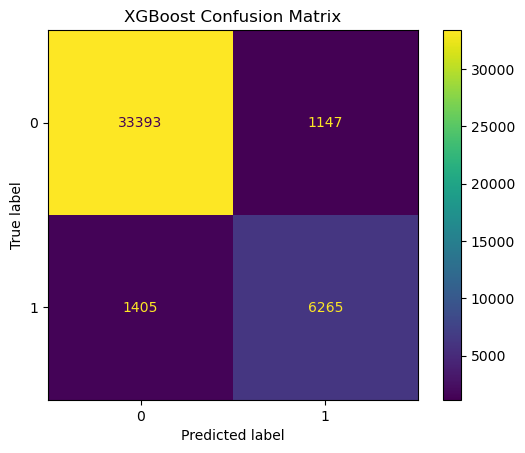

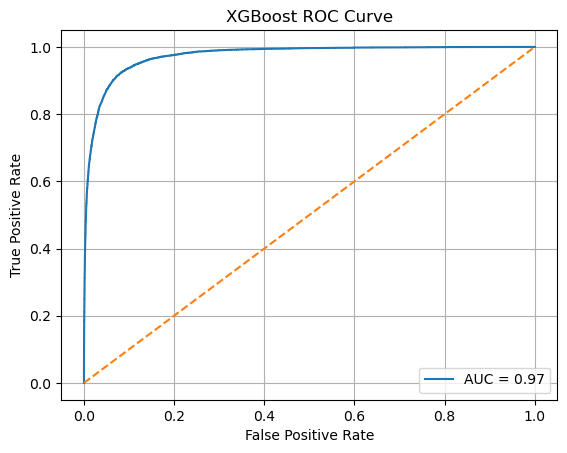

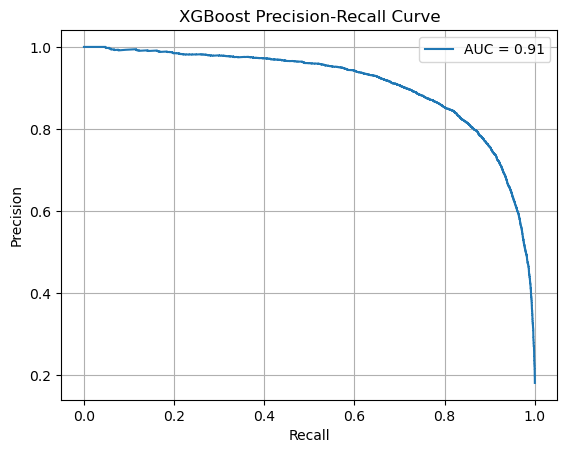


📊  KNN (k=15) Evaluation Metrics
Accuracy : 0.9280
Precision: 0.8035
Recall   : 0.7992
F1 Score : 0.8014
ROC AUC  : 0.9572


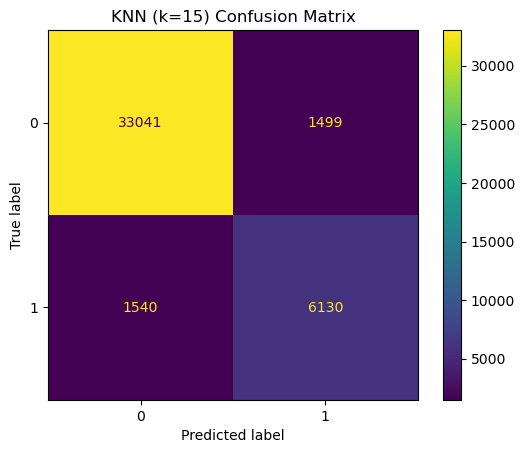

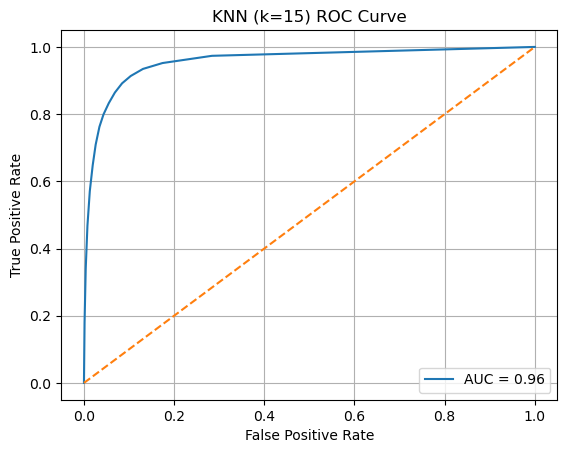

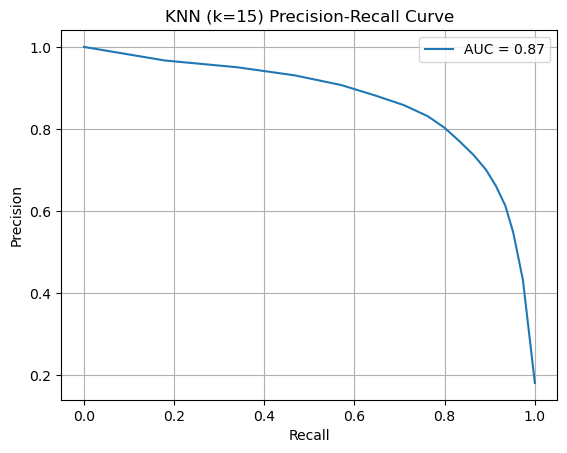


📊  Lasso Evaluation Metrics
Accuracy : 0.9378
Precision: 0.8438
Recall   : 0.8069
F1 Score : 0.8249
ROC AUC  : 0.9736


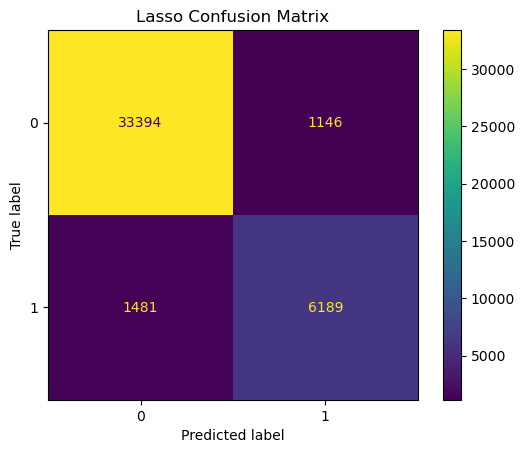

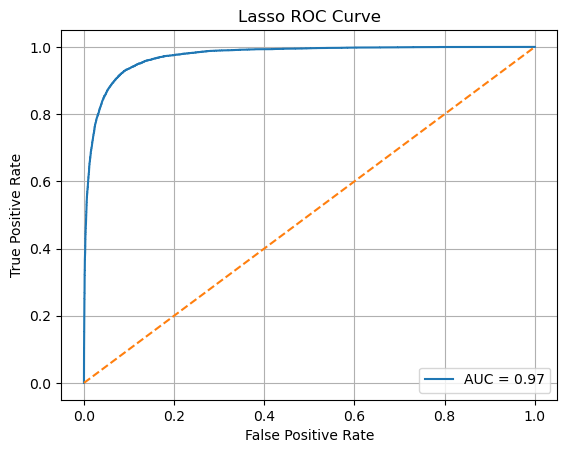

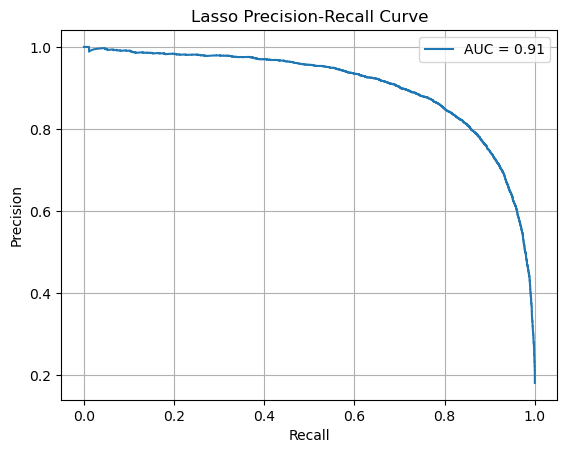


📊  Random Forest Evaluation Metrics
Accuracy : 0.9362
Precision: 0.8446
Recall   : 0.7950
F1 Score : 0.8191
ROC AUC  : 0.9713


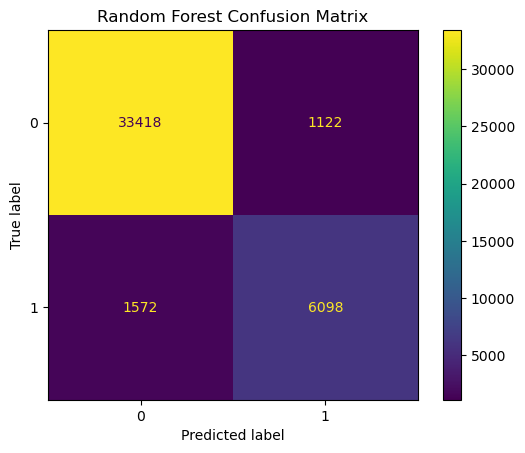

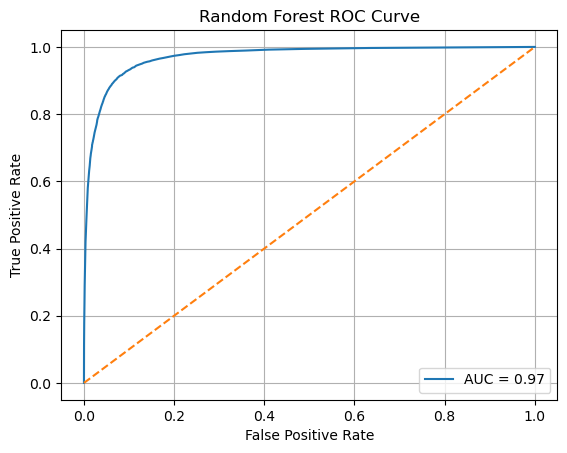

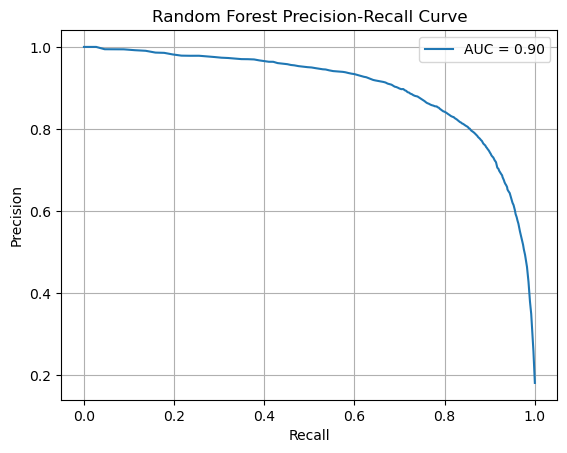


📋 Model Comparison Table
           Model  Accuracy  Precision    Recall  F1 Score   ROC AUC  \
0        XGBoost  0.939540   0.845251  0.816819  0.830792  0.974388   
1     KNN (k=15)  0.928003   0.803513  0.799218  0.801360  0.957152   
2          Lasso  0.937764   0.843763  0.806910  0.824925  0.973563   
3  Random Forest  0.936176   0.844598  0.795046  0.819073  0.971295   

   Run Time (s)  
0      0.732260  
1     58.390392  
2      0.132705  
3      2.325968  


In [43]:
# Run evaluations
xgb_prob = xgb_model.predict_proba(X_val)[:, 1]
xgb_results = evaluate_model("XGBoost", y_val, xgb_preds, xgb_prob, xgb_time)

knn_prob = knn_model.predict_proba(X_val)[:, 1]
knn_results = evaluate_model(f"KNN (k={optimal_k})", y_val, knn_preds, knn_prob, knn_time)

lasso_prob = lasso_model.predict_proba(X_val)[:, 1]
lasso_results = evaluate_model("Lasso", y_val, lasso_preds, lasso_prob, lasso_time)

rf_prob = rf_model.predict_proba(X_val)[:, 1]
rf_results = evaluate_model("Random Forest", y_val, rf_preds, rf_prob, rf_time)

# Comparison table
comparison_df = pd.DataFrame([xgb_results, knn_results, lasso_results, rf_results])
print("\n📋 Model Comparison Table")
print(comparison_df)

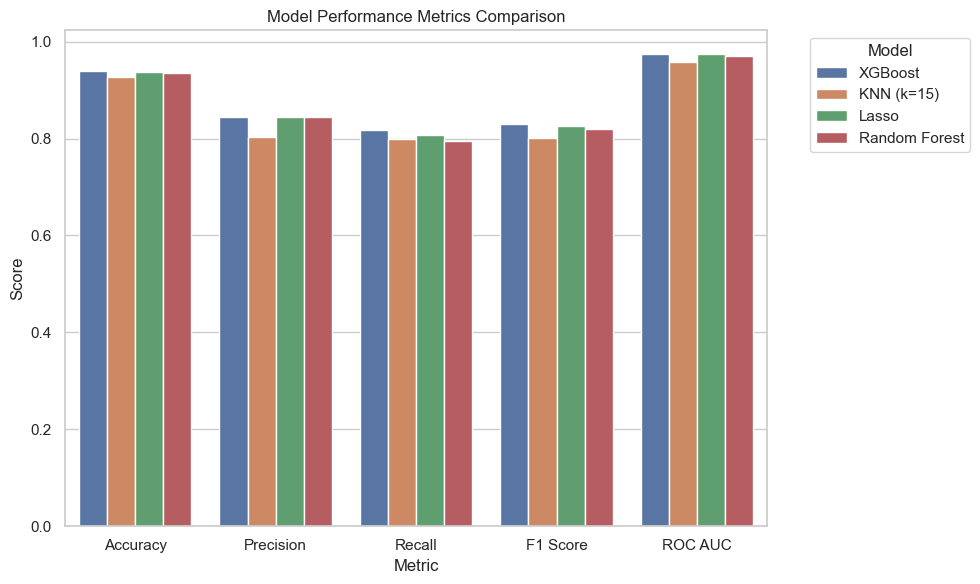

In [51]:
# Model comparison table as dataframe
df = pd.DataFrame(comparison_df)

# Make plot grouping metrics together 
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
df_melted = df.melt(id_vars='Model', value_vars=metrics, var_name='Metric', value_name='Score')
plt.figure(figsize=(10, 6))
ax1 = sns.barplot(data=df_melted, x='Metric', y='Score', hue='Model')
plt.title('Model Performance Metrics Comparison')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

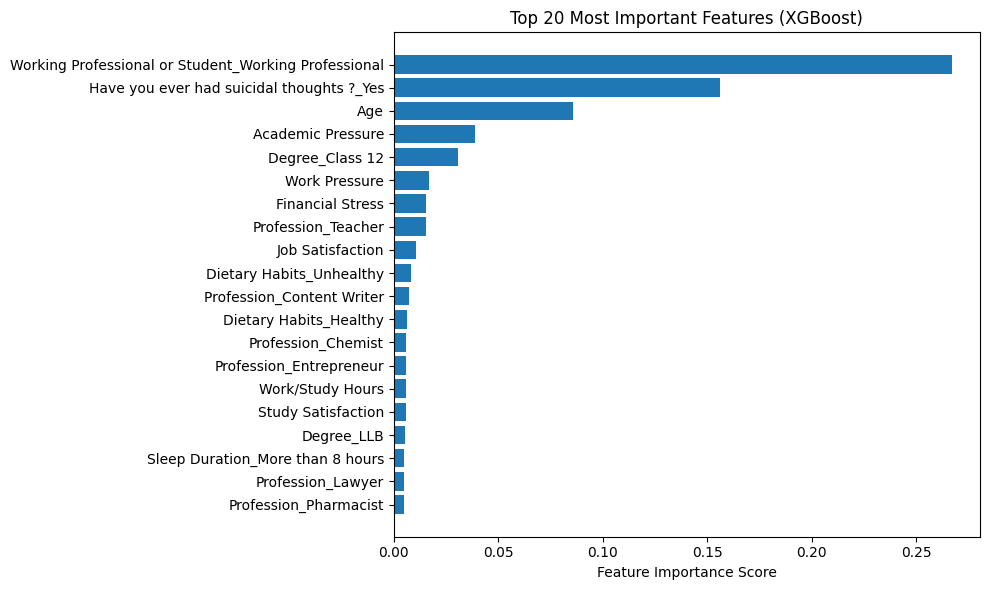

In [37]:
# Feature importance for XGBoost
importances = xgb_model.feature_importances_
feature_names = X_train.columns
sorted_idx = np.argsort(importances)[::-1][:20]  # Top 20 features

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx][::-1], align='center')
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx][::-1])
plt.xlabel('Feature Importance Score')
plt.title('Top 20 Most Important Features (XGBoost)')
plt.tight_layout()
plt.show()

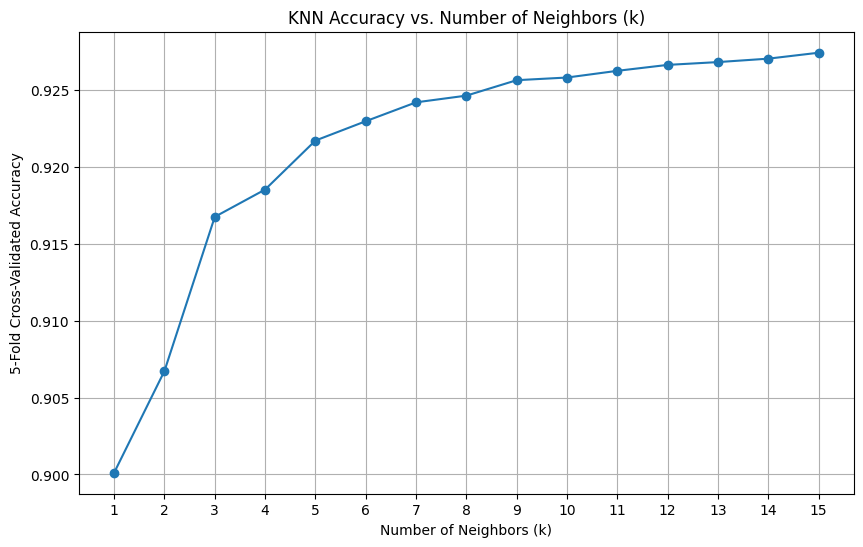

In [38]:
# Visual of selecting best k
plt.figure(figsize=(10, 6))
plt.plot(k_range, cv_scores, marker='o')
plt.xticks(k_range)
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("5-Fold Cross-Validated Accuracy")
plt.title("KNN Accuracy vs. Number of Neighbors (k)")
plt.grid(True)
plt.show()

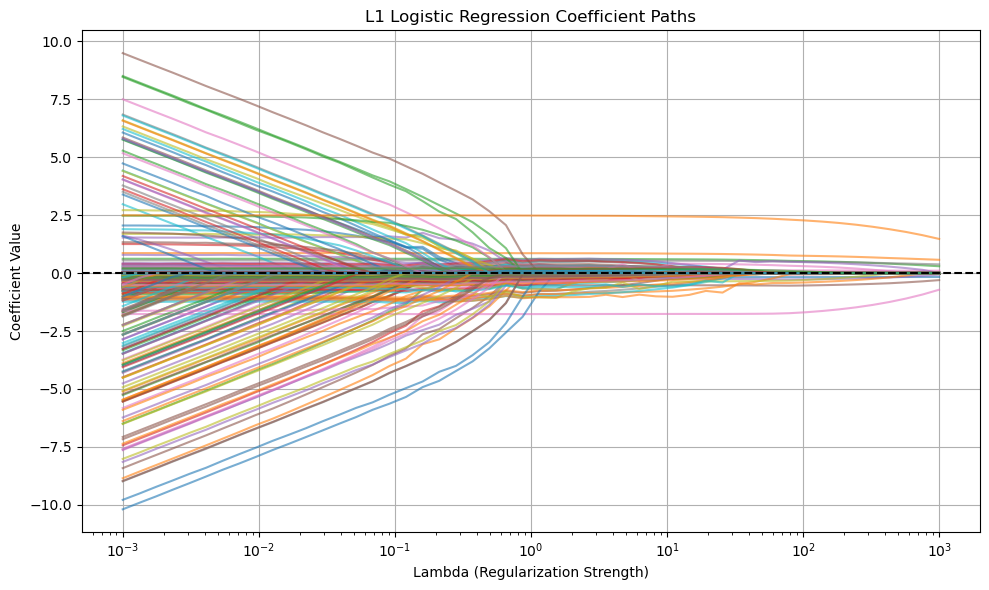

Selected features: ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress', 'Gender_Male', 'City_Aaradhya', 'City_Aditya', 'City_Agra', 'City_Ahmedabad', 'City_Anvi', 'City_Armaan', 'City_Atharv', 'City_Ayush', 'City_Bangalore', 'City_Bhavna', 'City_Bhopal', 'City_Chennai', 'City_Chhavi', 'City_City', 'City_Delhi', 'City_Faridabad', 'City_Galesabad', 'City_Gaurav', 'City_Ghaziabad', 'City_Gurgaon', 'City_Harsha', 'City_Hyderabad', 'City_Indore', 'City_Jaipur', 'City_Kagan', 'City_Kalyan', 'City_Kanpur', 'City_Kashish', 'City_Kashk', 'City_Keshav', 'City_Khaziabad', 'City_Khushi', 'City_Kibara', 'City_Kolkata', 'City_Krinda', 'City_Less Delhi', 'City_Less than 5 Kalyan', 'City_Lucknow', 'City_Ludhiana', 'City_M.Com', 'City_ME', 'City_Mahi', 'City_Meerut', 'City_Mihir', 'City_Mira', 'City_Molkata', 'City_Moreadhyay', 'City_Morena', 'City_Mumbai', 'City_Nagpur', 'City_Nalini', 'City_Nalyan', 'City_Nandini', 'Ci

In [36]:
# Generate lambda values as the inverse of C
lambdas = 1 / np.logspace(-3, 3, 50)
coefs = []

# Fit the model for each value of C
for C in np.logspace(-3, 3, 50):
    model = LogisticRegression(penalty='l1', solver='liblinear', C=C, random_state=42)
    model.fit(X_train, y_train)
    coefs.append(model.coef_[0])

coefs = np.array(coefs)

# Plotting the coefficient paths against lambda
plt.figure(figsize=(10, 6))
for i, coef_path in enumerate(coefs.T):
    plt.plot(lambdas, coef_path, label=X_train.columns[i], alpha=0.6)

plt.xscale("log")
plt.xlabel("Lambda (Regularization Strength)")
plt.ylabel("Coefficient Value")
plt.title("L1 Logistic Regression Coefficient Paths")
plt.axhline(0, color='black', linestyle='--')
plt.grid()
plt.tight_layout()
plt.show()

# Selected features from final model
coefs_final = model.coef_[0]
selected_features = [i for i, c in enumerate(coefs_final) if c != 0]

# Print feature names of selected features
selected_feature_names = [X_train.columns[i] for i in selected_features]
print(f"Selected features: {selected_feature_names}")
print(f"Number of features left in the model: {len(selected_feature_names)}")

In [44]:
# Identify removed features
all_features = X_train.columns
dropped_feature_names = [feature for i, feature in enumerate(all_features) if coefs_final[i] == 0]
print(f"Dropped features: {dropped_feature_names}")
print(f"Number of features dropped: {len(dropped_feature_names)}")

# Identify best lambda
print("Best lambda (1/C):", 1 / grid_search.best_params_['C'])

Dropped features: ['City_Aishwarya', 'City_Ayansh', 'City_Dhruv', 'City_Harsh', 'City_Ishanabad', 'City_Ishkarsh', 'City_Ithal', 'City_Itheg', 'City_Ivaan', 'City_Jhanvi', 'City_Krishna', 'City_M.Tech', 'City_MCA', 'City_MSc', 'City_Malyansh', 'City_No', 'City_Parth', 'City_Plata', 'City_Pooja', 'City_Raghavendra', 'City_Rashi', 'City_Reyansh', 'City_Shrey', 'City_Tolkata', 'City_Tushar', 'City_Unirar', 'City_Vaishnavi', 'Profession_B.Ed', 'Profession_City Manager', 'Profession_Family Consultant', 'Profession_FamilyVirar', 'Profession_LLM', 'Profession_M.Ed', 'Profession_Medical Doctor', 'Profession_Nagpur', 'Profession_Pranav', 'Profession_Unveil', 'Profession_Visakhapatnam', 'Profession_Yuvraj', 'Sleep Duration_1-3 hours', 'Sleep Duration_10-6 hours', 'Sleep Duration_3-6 hours', 'Sleep Duration_35-36 hours', 'Sleep Duration_49 hours', 'Sleep Duration_55-66 hours', 'Sleep Duration_9-5', 'Sleep Duration_Work_Study_Hours', 'Dietary Habits_2', 'Dietary Habits_Class 12', 'Dietary Habits_I

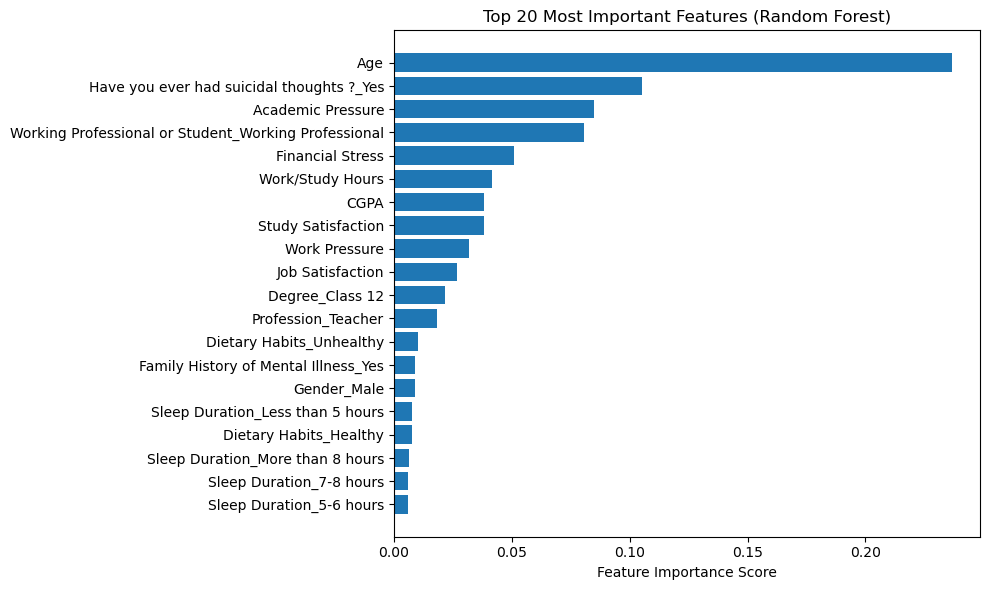

In [26]:
# Feature importance for Random Forest
rf_importances = rf_model.feature_importances_
sorted_idx = np.argsort(rf_importances)[::-1][:20]

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), rf_importances[sorted_idx][::-1], align='center')
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx][::-1])
plt.xlabel('Feature Importance Score')
plt.title('Top 20 Most Important Features (Random Forest)')
plt.tight_layout()
plt.show()